### Optimized models (dataset 6) 

##### Optimized models, one for each combination between groups formed and features of physiological signals, for dataset 6, and using the optimal features and optimal hyperparameters obtained previously.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from time import time 
import random
import itertools
from itertools import repeat

from scipy import stats
from scipy.spatial.distance import pdist, squareform 
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.stats.anova import AnovaRM

from sklearn.utils import shuffle
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, ShuffleSplit, GroupShuffleSplit
from sklearn.feature_selection import SelectFromModel

In [2]:
def acess_data (filename,sheetname):

    #Acessing data
    data = pd.read_excel(filename,sheet_name=sheetname)
        
    #Standardizatin Excerpts
    feat = data.drop(['Labels','Participante', 'Excerpt'], axis=1).columns
    scaler = MinMaxScaler()
    data[feat] = scaler.fit_transform(data[feat])
        
    return data

In [9]:
def emotional_model (C, gamma, kernel, xtrain, ytrain, xtest, ytest):
    
    # Classifier
    emotional_model = SVC(C=C,gamma=gamma,kernel=kernel)
    
    # Fitting
    emotional_model.fit(xtrain,ytrain)
    
    # Predicting
    predictions_train = emotional_model.predict(xtrain)
    predictions_test = emotional_model.predict(xtest)
    
    results_train = pd.DataFrame()
    results_test = pd.DataFrame()
    results_train['Truth'] = ytrain
    results_test['Truth'] = ytest
    results_train['Predicted Emotion Train'] = predictions_train
    results_test['Predicted Emotion Test'] = predictions_test
    
    # Classification report
    print('\nClassification Report Train:')
    train_rep = classification_report(ytrain,predictions_train, digits=3)
    dic_train = classification_report(ytrain,predictions_train, digits=3, output_dict=True)
    print(train_rep)
    print('\nClassification Report Test:')
    test_rep= classification_report(ytest,predictions_test, digits=3)
    dic_test = classification_report(ytest,predictions_test, digits=3, output_dict=True)
    print(test_rep)
    
    print('--------------------------------------------------------------------------------')
    
    return emotional_model, results_train, results_test, dic_train, dic_test, predictions_test

In [4]:
def cross_validation (data, optimal_feat, split3, split4, binary1, binary2, C, gamma, kernel, X):
    
    dic = {}
    
    for i in range(0, X):
    
        dic[i]={}
               
        if split3==True:
            train, test = train_test_equal_part_emotion (data)
            
        elif split4==True:
            train, test = split_Discrete (data, binary1, binary2)
        
        x_train = train[optimal_feat].values
        x_test = test[optimal_feat].values
        y_train = train['Labels'].values
        y_test = test['Labels'].values
        
        # Index of train and test
        index_train = train.index.tolist()
        index_test = test.index.tolist()

        # Emotional Model
        model, results_train, results_test, dic_train, dic_test = emotional_model (C, gamma, kernel, x_train, y_train, 
                                                                                   x_test, y_test)
        
        print('\n')        
        # Creating dictionary with information of each run
        if split3==True:
            dic[i] = {'AccuracyTrain':dic_train['accuracy'], 'AccuracyTest':dic_test['accuracy'], 
                      'FearTrain':dic_train['Fear']['f1-score'], 'FearTest':dic_test['Fear']['f1-score'], 
                      'HappyTrain':dic_train['Happy']['f1-score'], 'HappyTest':dic_test['Happy']['f1-score'],
                      'NeutralTrain':dic_train['Neutral']['f1-score'], 'NeutralTest':dic_test['Neutral']['f1-score'], 
                      'IndexTrain': index_train, 'IndexTest':index_test}
            
        elif split4==True:
            dic[i] = {'AccuracyTrain':dic_train['accuracy'], 'AccuracyTest':dic_test['accuracy'], 
                      'Emotion1Train':dic_train[binary1]['f1-score'], 'Emotion1Test':dic_test[binary1]['f1-score'], 
                      'Emotion2Train':dic_train[binary2]['f1-score'], 'Emotion2Test':dic_test[binary2]['f1-score'], 
                      'IndexTrain': index_train, 'IndexTest':index_test}

    # Printing Results
    print('----------------------------------------Final Results----------------------------------------')
    results = pd.DataFrame.from_dict(dic, orient='index')
    
    if split3==True:
        print('\nTrain Results:')
        print('\nAverage Accuracy: ', results.AccuracyTrain.mean())
        print('\nStandard Deviation Accuracy: ', results.AccuracyTrain.std())
        print('\nAverage Accuracy - Fear: ', results.FearTrain.mean())
        print('Average Accuracy - Happy: ', results.HappyTrain.mean())
        print('Average Accuracy - Neutral: ', results.NeutralTrain.mean())
    
        print('\nTest Results')
        print('\nAverage Accuracy: ', results.AccuracyTest.mean())
        print('\nStandard Deviation Accuracy: ', results.AccuracyTest.std())
        print('Max Accuracy: ', results.AccuracyTest.max())
        print('Min Accuracy: ', results.AccuracyTest.min())        
        print('\nAverage Accuracy - Fear: ', results.FearTest.mean())
        print('Average Accuracy - Happy: ', results.HappyTest.mean())
        print('Average Accuracy - Neutral: ', results.NeutralTest.mean())
        
    elif split4==True:
        print('\nTrain Results:')
        print('\nAverage Accuracy: ', results.AccuracyTrain.mean())
        print('\nStandard Deviation Accuracy: ', results.AccuracyTrain.std())
        print('\nAverage Accuracy - Emotion1: ', results.Emotion1Train.mean())
        print('Average Accuracy - Emotion2: ', results.Emotion2Train.mean())
    
        print('\nTest Results')
        print('\nAverage Accuracy: ', results.AccuracyTest.mean())
        print('\nStandard Deviation Accuracy: ', results.AccuracyTest.std())
        print('Max Accuracy: ', results.AccuracyTest.max())
        print('Min Accuracy: ', results.AccuracyTest.min())
        print('\nAverage Accuracy - Emotion1: ', results.Emotion1Test.mean())
        print('Average Accuracy - Emotion2: ', results.Emotion2Test.mean())
    
    return results

In [5]:
run = 30

In [67]:
# Geral_ECG_EMG_EDA:
optimal_feat = ['EMG_MF_Activations_N', 'EMG_MF_all_Amplitude_Kurt', 'EMG_TR_MeanPeaksAct_Skew', 'EMG_TR_all_Amplitude_Kurt', 'EDA_SympN', 'SCR_Peaks_N', 'EDA_Phasic_Mean', 'SCR_Height_Var', 'SCR_Amplitude_Skew', 'SCR_RiseTime_Skew', 'SCR_RecoveryTime_Mean', 'SCR_RecoveryTime_Skew', 'ECG_Tduration_Var', 'ECG_Tduration_Skew', 'HRV_MinNN', 'HRV_LFn', 'HRV_CSI_Modified', 'HRV_LF', 'HRV_PSS', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha2_Width', 'HRV_MFDFA_alpha2_Fluctuation', 'HRV_MFDFA_alpha2_Max', 'HRV_KFD']

In [68]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='Geral_ECG+EMG+EDA')

In [69]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_best_results', 'rb'))
print(best_results)

C                                                            100.0
gamma                                                          0.1
degree                                                           4
kernel                                                        poly
AccuracyTrain                                             0.735632
AccuracyTest                                              0.689655
FearTrain                                                 0.728745
FearTest                                                  0.698413
HappyTrain                                                0.716814
HappyTest                                                 0.627451
NeutralTrain                                              0.762332
NeutralTest                                               0.733333
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 16, 1...
IndexTest        [14, 5, 0, 25, 20, 15, 40, 35, 34, 59, 50, 49,...
Name: 15, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.701     0.767     0.733       116
       Happy      0.748     0.716     0.731       116
     Neutral      0.800     0.759     0.779       116

    accuracy                          0.747       348
   macro avg      0.750     0.747     0.748       348
weighted avg      0.750     0.747     0.748       348


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.688     0.759     0.721        29
       Happy      0.739     0.586     0.654        29
     Neutral      0.688     0.759     0.721        29

    accuracy                          0.701        87
   macro avg      0.705     0.701     0.699        87
weighted avg      0.705     0.701     0.699        87

--------------------------------------------------------------------------------


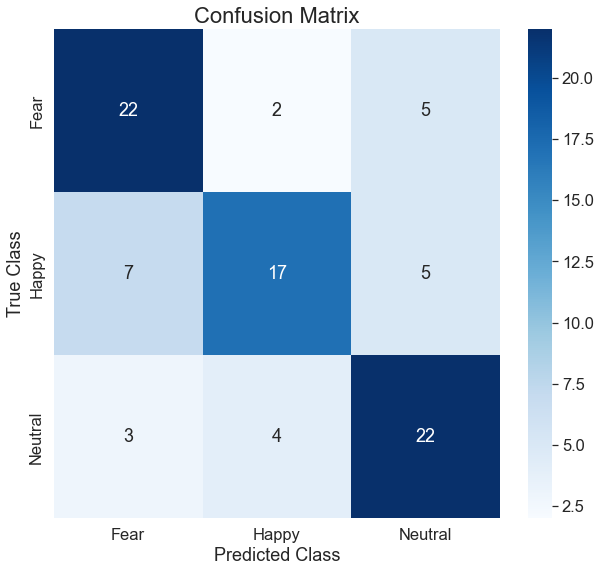

In [70]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [6]:
# G1_ECG_EMG_EDA:

optimal_feat = ['EMG_MF_Duration_Skew', 'EDA_SympN', 'EDA_Tonic_Mean', 'EDA_Tonic_Var', 'ECG_Rate_Mean', 'ECG_Tduration_Mean', 'ECG_Tduration_Skew', 'HRV_GI', 'HRV_PI', 'HRV_MFDFA_alpha2_Width', 'HRV_MFDFA_alpha2_Max', 'HRV_KFD']

In [7]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G1_ECG+EMG+EDA')

In [8]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g1_ecg_eda_emg_best_results', 'rb'))
print(best_results)

C                                                              100
gamma                                                            -
degree                                                           -
kernel                                                      linear
AccuracyTrain                                             0.958333
AccuracyTest                                              0.916667
FearTrain                                                      1.0
FearTest                                                  0.857143
HappyTrain                                                  0.9375
HappyTest                                                 0.888889
NeutralTrain                                                0.9375
NeutralTest                                                    1.0
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 1...
IndexTest           [14, 5, 0, 25, 20, 19, 40, 35, 30, 55, 54, 45]
Name: 9, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      1.000     1.000     1.000        16
       Happy      0.938     0.938     0.938        16
     Neutral      0.938     0.938     0.938        16

    accuracy                          0.958        48
   macro avg      0.958     0.958     0.958        48
weighted avg      0.958     0.958     0.958        48


Classification Report Test:
              precision    recall  f1-score   support

        Fear      1.000     0.750     0.857         4
       Happy      0.800     1.000     0.889         4
     Neutral      1.000     1.000     1.000         4

    accuracy                          0.917        12
   macro avg      0.933     0.917     0.915        12
weighted avg      0.933     0.917     0.915        12

--------------------------------------------------------------------------------


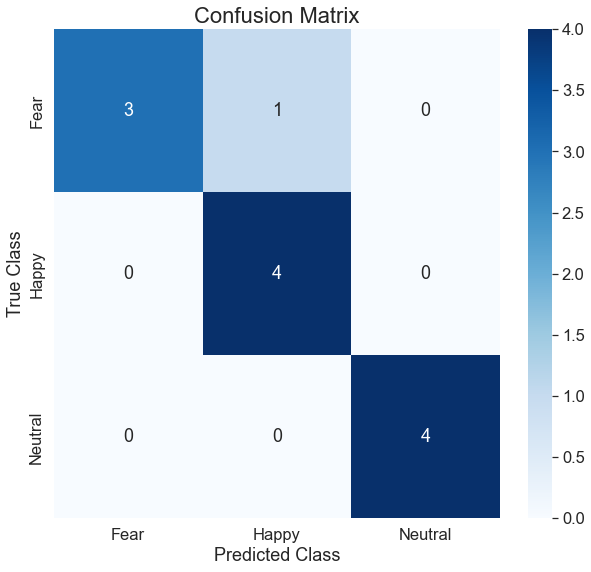

In [10]:
C_parameter = best_results['C']
gamma_parameter = 'auto'
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [11]:
# G2_ECG_EMG_EDA:

optimal_feat = ['EMG_MF_Activations_N', 'EMG_MF_Duration_Var', 'EMG_MF_Duration_Skew', 'EMG_MF_Duration_Kurt', 'EMG_MF_MeanPeaksAct_Skew', 'EMG_MF_MeanPeaksAct_Kurt', 'EMG_TR_Activations_N', 'EMG_TR_Duration_Std', 'EMG_TR_Duration_Kurt', 'EMG_TR_MeanPeaksAct_Skew', 'EDA_SympN', 'SCR_Peaks_N', 'EDA_Tonic_Mean', 'EDA_Phasic_Skew', 'EDA_Phasic_Kurt', 'SCR_Height_Skew', 'SCR_Height_Kurt', 'SCR_Amplitude_Skew', 'SCR_RiseTime_Std', 'SCR_RecoveryTime_Var', 'SCR_RecoveryTime_Skew', 'SCR_RecoveryTime_Kurt', 'ECG_Rate_Skew', 'ECG_Tduration_Mean', 'ECG_Tduration_Var', 'ECG_Tduration_Skew', 'ECG_Tduration_Kurt', 'HRV_LFn', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_Ca', 'HRV_PI', 'HRV_MFDFA_alpha1_Asymmetry', 'HRV_MFDFA_alpha2_Width', 'HRV_MFDFA_alpha2_Peak', 'HRV_MFDFA_alpha2_Max', 'HRV_MFDFA_alpha2_Increment', 'HRV_KFD', 'HRV_CMSEn']

In [12]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G2_ECG+EMG+EDA')

In [13]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g2_ecg_eda_emg_best_results', 'rb'))
print(best_results)

C                                                             10.0
gamma                                                          0.1
degree                                                           -
kernel                                                         rbf
AccuracyTrain                                                 0.95
AccuracyTest                                                   0.8
FearTrain                                                     0.95
FearTest                                                      0.75
HappyTrain                                                0.923077
HappyTest                                                 0.769231
NeutralTrain                                               0.97561
NeutralTest                                               0.888889
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 1...
IndexTest        [10, 5, 0, 25, 20, 15, 40, 35, 30, 55, 50, 45,...
Name: 0, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.950     0.950     0.950        20
       Happy      0.947     0.900     0.923        20
     Neutral      0.952     1.000     0.976        20

    accuracy                          0.950        60
   macro avg      0.950     0.950     0.950        60
weighted avg      0.950     0.950     0.950        60


Classification Report Test:
              precision    recall  f1-score   support

        Fear      1.000     0.600     0.750         5
       Happy      0.625     1.000     0.769         5
     Neutral      1.000     0.800     0.889         5

    accuracy                          0.800        15
   macro avg      0.875     0.800     0.803        15
weighted avg      0.875     0.800     0.803        15

--------------------------------------------------------------------------------


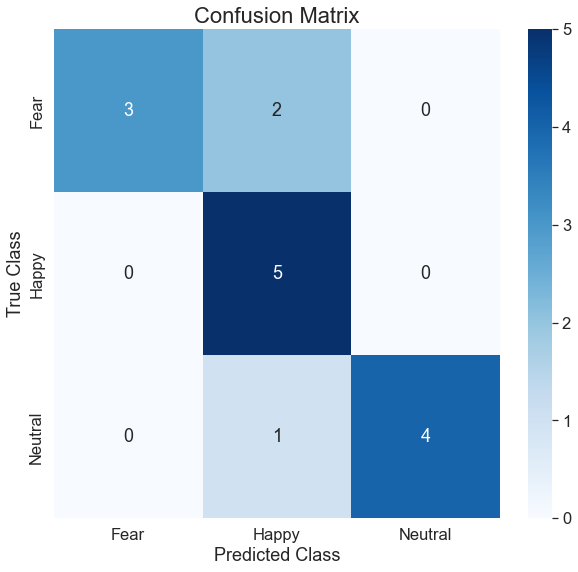

In [14]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [15]:
# G3_ECG_EMG_EDA:

optimal_feat = ['EMG_MF_Activations_N', 'EMG_MF_all_Amplitude_Kurt', 'EMG_TR_all_Amplitude_Kurt', 'EDA_SympN', 'EDA_Tonic_Mean', 'EDA_Phasic_Mean', 'SCR_Height_Var', 'SCR_Amplitude_Skew', 'SCR_RecoveryTime_Mean', 'ECG_Tduration_Var', 'ECG_Tduration_Skew', 'HRV_MinNN', 'HRV_LFn', 'HRV_CSI_Modified', 'HRV_LF', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha2_Width', 'HRV_MFDFA_alpha2_Fluctuation']

In [16]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G3_ECG+EMG+EDA')

In [17]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g3_ecg_eda_emg_best_results', 'rb'))
print(best_results)

C                                                             1000
gamma                                                         0.01
degree                                                           -
kernel                                                         rbf
AccuracyTrain                                             0.716667
AccuracyTest                                                  0.75
FearTrain                                                 0.714286
FearTest                                                  0.742857
HappyTrain                                                0.690476
HappyTest                                                 0.714286
NeutralTrain                                              0.746835
NeutralTest                                               0.790698
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...
IndexTest        [10, 5, 0, 25, 20, 19, 40, 39, 34, 55, 50, 49,...
Name: 12, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.743     0.688     0.714        80
       Happy      0.659     0.725     0.690        80
     Neutral      0.756     0.738     0.747        80

    accuracy                          0.717       240
   macro avg      0.720     0.717     0.717       240
weighted avg      0.720     0.717     0.717       240


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.867     0.650     0.743        20
       Happy      0.682     0.750     0.714        20
     Neutral      0.739     0.850     0.791        20

    accuracy                          0.750        60
   macro avg      0.763     0.750     0.749        60
weighted avg      0.763     0.750     0.749        60

--------------------------------------------------------------------------------


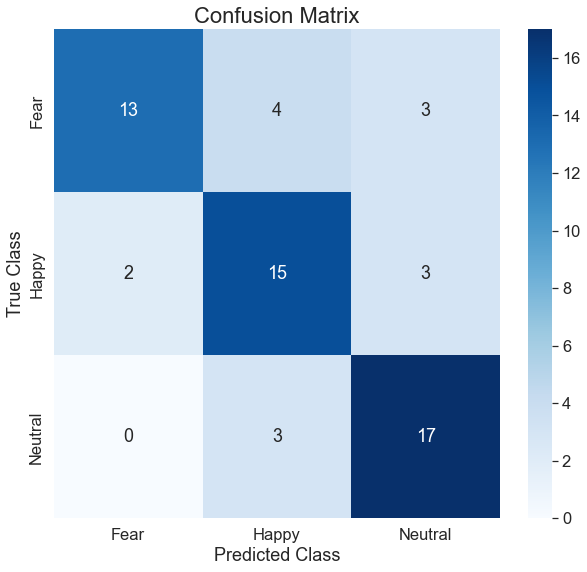

In [18]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [19]:
# Geral_ECG:

optimal_feat = ['HRV_LFn', 'HRV_CSI_Modified', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha2_Width', 'HRV_MFDFA_alpha2_Fluctuation']

In [20]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='Geral_ECG')

In [21]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_geral_ecg_best_results', 'rb'))
print(best_results)

C                                                               10
gamma                                                            1
degree                                                           2
kernel                                                        poly
AccuracyTrain                                             0.632184
AccuracyTest                                              0.712644
FearTrain                                                 0.472906
FearTest                                                  0.653846
HappyTrain                                                0.614865
HappyTest                                                 0.684932
NeutralTrain                                              0.822335
NeutralTest                                               0.816327
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 1...
IndexTest        [14, 5, 0, 25, 20, 19, 40, 35, 30, 55, 50, 49,...
Name: 28, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.565     0.448     0.500       116
       Happy      0.503     0.750     0.602       116
     Neutral      1.000     0.716     0.834       116

    accuracy                          0.638       348
   macro avg      0.689     0.638     0.645       348
weighted avg      0.689     0.638     0.645       348


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.654     0.586     0.618        29
       Happy      0.537     0.759     0.629        29
     Neutral      1.000     0.690     0.816        29

    accuracy                          0.678        87
   macro avg      0.730     0.678     0.688        87
weighted avg      0.730     0.678     0.688        87

--------------------------------------------------------------------------------


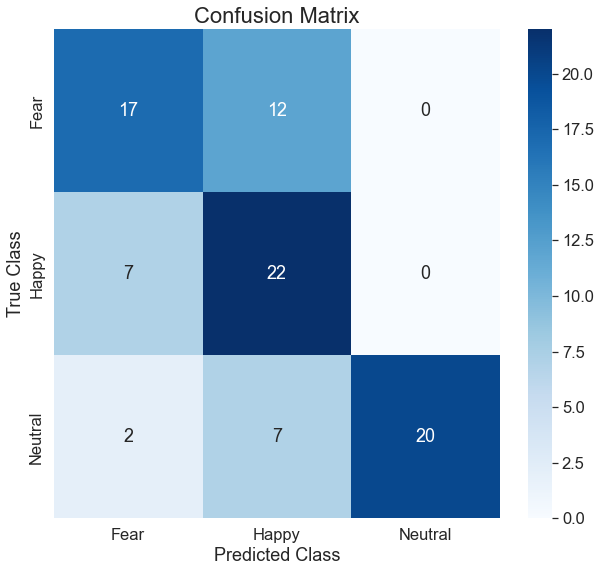

In [22]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [23]:
# G1_ECG:

optimal_feat = ['ECG_Rate_Mean','ECG_Rate_Skew','ECG_Rate_Kurt','ECG_Tduration_Mean','ECG_Tduration_Var','ECG_Tduration_Skew','ECG_Tduration_Kurt','HRV_TINN','HRV_MinNN','HRV_LFn','HRV_CSI_Modified','HRV_LF','HRV_PSS','HRV_PAS','HRV_GI','HRV_Ca','HRV_PI','HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Fluctuation','HRV_MFDFA_alpha1_Asymmetry','HRV_MFDFA_alpha1_Increment','HRV_MFDFA_alpha2_Width','HRV_MFDFA_alpha2_Peak','HRV_MFDFA_alpha2_Asymmetry','HRV_MFDFA_alpha2_Fluctuation','HRV_MFDFA_alpha2_Max','HRV_MFDFA_alpha2_Increment', 'HRV_RCMSEn','HRV_MSEn','HRV_KFD','HRV_CMSEn']                        


In [24]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G1_ECG')

In [25]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g1_ecg_best_results', 'rb'))
print(best_results)

C                                                            100.0
gamma                                                         0.01
degree                                                           -
kernel                                                         rbf
AccuracyTrain                                                0.875
AccuracyTest                                              0.666667
FearTrain                                                 0.896552
FearTest                                                       0.8
HappyTrain                                                0.857143
HappyTest                                                     0.75
NeutralTrain                                                 0.875
NeutralTest                                               0.333333
IndexTrain       [0, 1, 2, 3, 5, 6, 7, 8, 11, 12, 13, 14, 16, 1...
IndexTest           [10, 9, 4, 25, 20, 15, 40, 35, 30, 59, 50, 45]
Name: 7, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      1.000     0.812     0.897        16
       Happy      0.789     0.938     0.857        16
     Neutral      0.875     0.875     0.875        16

    accuracy                          0.875        48
   macro avg      0.888     0.875     0.876        48
weighted avg      0.888     0.875     0.876        48


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.667     1.000     0.800         4
       Happy      0.750     0.750     0.750         4
     Neutral      0.500     0.250     0.333         4

    accuracy                          0.667        12
   macro avg      0.639     0.667     0.628        12
weighted avg      0.639     0.667     0.628        12

--------------------------------------------------------------------------------


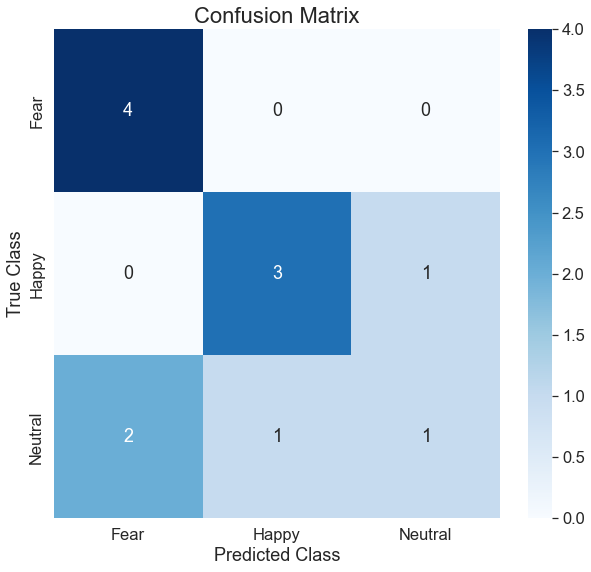

In [26]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [27]:
# G2_ECG:

optimal_feat = ['ECG_Rate_Mean', 'ECG_Rate_Skew', 'ECG_Rate_Kurt', 'ECG_Tduration_Mean', 'ECG_Tduration_Var', 'ECG_Tduration_Skew', 'ECG_Tduration_Kurt', 'HRV_TINN', 'HRV_LFn', 'HRV_CSI_Modified', 'HRV_LF', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_Ca', 'HRV_PI', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Fluctuation', 'HRV_MFDFA_alpha1_Asymmetry', 'HRV_MFDFA_alpha2_Width', 'HRV_MFDFA_alpha2_Peak', 'HRV_MFDFA_alpha2_Fluctuation', 'HRV_MFDFA_alpha2_Max', 'HRV_MFDFA_alpha2_Increment', 'HRV_RCMSEn', 'HRV_MSEn', 'HRV_KFD', 'HRV_CMSEn']

In [28]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G2_ECG')

In [29]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g2_ecg_best_results', 'rb'))
print(best_results)

C                                                             10.0
gamma                                                            1
degree                                                           -
kernel                                                         rbf
AccuracyTrain                                                  1.0
AccuracyTest                                              0.733333
FearTrain                                                      1.0
FearTest                                                  0.666667
HappyTrain                                                     1.0
HappyTest                                                      0.6
NeutralTrain                                                   1.0
NeutralTest                                               0.909091
IndexTrain       [0, 1, 2, 3, 5, 6, 7, 8, 11, 12, 13, 14, 16, 1...
IndexTest        [10, 9, 4, 29, 20, 15, 40, 35, 30, 55, 50, 49,...
Name: 20, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      1.000     1.000     1.000        20
       Happy      1.000     1.000     1.000        20
     Neutral      1.000     1.000     1.000        20

    accuracy                          1.000        60
   macro avg      1.000     1.000     1.000        60
weighted avg      1.000     1.000     1.000        60


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.750     0.600     0.667         5
       Happy      0.600     0.600     0.600         5
     Neutral      0.833     1.000     0.909         5

    accuracy                          0.733        15
   macro avg      0.728     0.733     0.725        15
weighted avg      0.728     0.733     0.725        15

--------------------------------------------------------------------------------


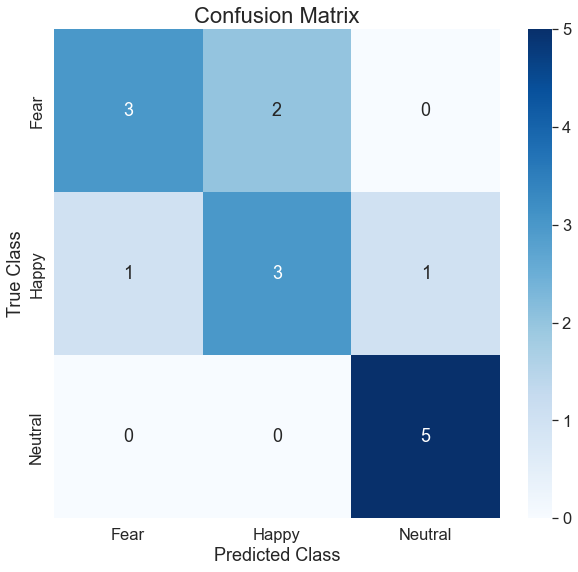

In [30]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [31]:
# G3_ECG:

optimal_feat = ['ECG_Tduration_Var', 'ECG_Tduration_Skew', 'ECG_Tduration_Kurt', 'HRV_LFn', 'HRV_LF', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha2_Width', 'HRV_MFDFA_alpha2_Fluctuation']

In [32]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G3_ECG')

In [33]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g3_ecg_best_results', 'rb'))
print(best_results)

C                                                              100
gamma                                                          0.1
degree                                                           -
kernel                                                         rbf
AccuracyTrain                                             0.683333
AccuracyTest                                              0.783333
FearTrain                                                 0.645161
FearTest                                                  0.777778
HappyTrain                                                0.631016
HappyTest                                                 0.734694
NeutralTrain                                              0.797101
NeutralTest                                               0.857143
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 1...
IndexTest        [10, 5, 0, 29, 20, 15, 40, 39, 30, 55, 50, 49,...
Name: 22, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.667     0.625     0.645        80
       Happy      0.551     0.738     0.631        80
     Neutral      0.948     0.688     0.797        80

    accuracy                          0.683       240
   macro avg      0.722     0.683     0.691       240
weighted avg      0.722     0.683     0.691       240


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.875     0.700     0.778        20
       Happy      0.621     0.900     0.735        20
     Neutral      1.000     0.750     0.857        20

    accuracy                          0.783        60
   macro avg      0.832     0.783     0.790        60
weighted avg      0.832     0.783     0.790        60

--------------------------------------------------------------------------------


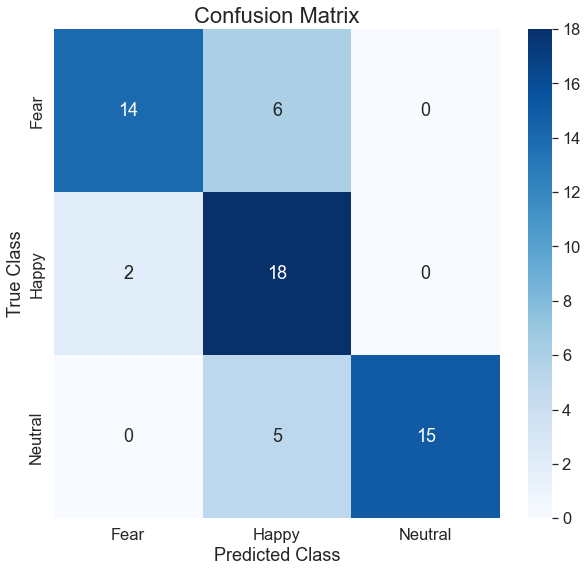

In [34]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [35]:
# Geral_EDA:

optimal_feat = ['EDA_SympN', 'EDA_Tonic_Mean', 'EDA_Tonic_Var', 'SCR_Height_Var', 'SCR_Amplitude_Skew', 'SCR_RiseTime_Skew', 'SCR_RecoveryTime_Mean', 'SCR_RecoveryTime_Skew']

In [36]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='Geral_EDA')

In [37]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_geral_eda_best_results', 'rb'))
print(best_results)

C                                                             10.0
gamma                                                          1.0
degree                                                           6
kernel                                                        poly
AccuracyTrain                                             0.701149
AccuracyTest                                              0.563218
FearTrain                                                 0.725581
FearTest                                                  0.653846
HappyTrain                                                0.684015
HappyTest                                                 0.638889
NeutralTrain                                              0.698113
NeutralTest                                                   0.36
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 1...
IndexTest        [10, 5, 0, 25, 20, 15, 40, 35, 30, 55, 50, 49,...
Name: 3, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.695     0.569     0.626       116
       Happy      0.500     0.543     0.521       116
     Neutral      0.575     0.629     0.601       116

    accuracy                          0.580       348
   macro avg      0.590     0.580     0.582       348
weighted avg      0.590     0.580     0.582       348


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.391     0.310     0.346        29
       Happy      0.387     0.414     0.400        29
     Neutral      0.242     0.276     0.258        29

    accuracy                          0.333        87
   macro avg      0.340     0.333     0.335        87
weighted avg      0.340     0.333     0.335        87

--------------------------------------------------------------------------------


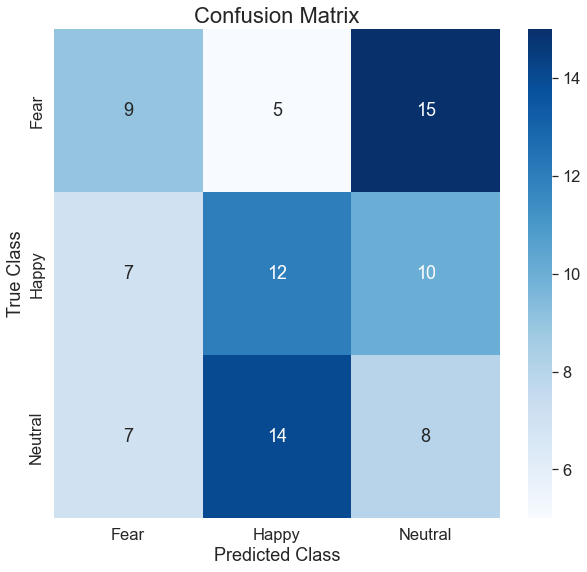

In [38]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [39]:
# G1_EDA:

optimal_feat = ['EDA_SympN', 'EDA_Tonic_Mean', 'EDA_Tonic_Var', 'EDA_Tonic_Skew', 'EDA_Phasic_Skew', 'EDA_Phasic_Kurt', 'SCR_Height_Var', 'SCR_Height_Kurt', 'SCR_Amplitude_Skew', 'SCR_RiseTime_Std', 'SCR_RiseTime_Skew', 'SCR_RiseTime_Kurt', 'SCR_RecoveryTime_Skew']

In [40]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G1_EDA')

In [41]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g1_eda_best_results', 'rb'))
print(best_results)

C                                                              1.0
gamma                                                            1
degree                                                           -
kernel                                                         rbf
AccuracyTrain                                                 0.75
AccuracyTest                                              0.666667
FearTrain                                                 0.608696
FearTest                                                  0.666667
HappyTrain                                                0.727273
HappyTest                                                      0.8
NeutralTrain                                              0.896552
NeutralTest                                                    0.5
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 1...
IndexTest           [14, 5, 0, 25, 20, 19, 40, 35, 30, 55, 50, 45]
Name: 6, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      1.000     0.438     0.609        16
       Happy      0.571     1.000     0.727        16
     Neutral      1.000     0.812     0.897        16

    accuracy                          0.750        48
   macro avg      0.857     0.750     0.744        48
weighted avg      0.857     0.750     0.744        48


Classification Report Test:
              precision    recall  f1-score   support

        Fear      1.000     0.500     0.667         4
       Happy      0.667     1.000     0.800         4
     Neutral      0.500     0.500     0.500         4

    accuracy                          0.667        12
   macro avg      0.722     0.667     0.656        12
weighted avg      0.722     0.667     0.656        12

--------------------------------------------------------------------------------


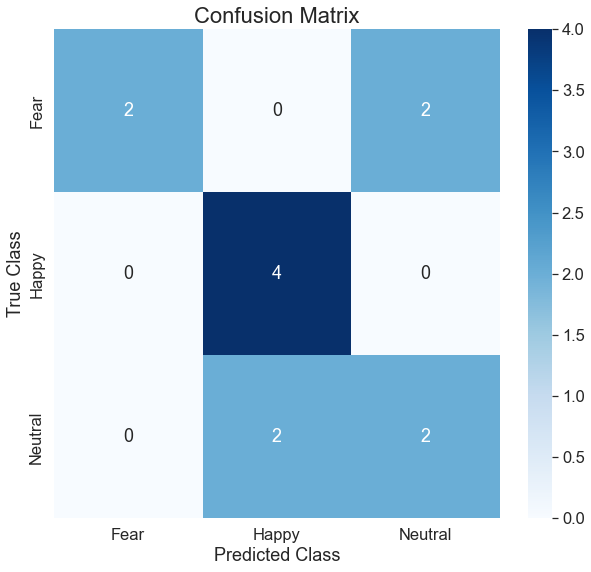

In [42]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [43]:
# G2_EDA:

optimal_feat = ['SCR_Height_Skew']

In [44]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G2_EDA')

In [45]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g2_eda_best_results', 'rb'))
print(best_results)

C                                                             10.0
gamma                                                            1
degree                                                           -
kernel                                                         rbf
AccuracyTrain                                             0.483333
AccuracyTest                                              0.466667
FearTrain                                                 0.588235
FearTest                                                  0.333333
HappyTrain                                                     0.4
HappyTest                                                 0.666667
NeutralTrain                                              0.411765
NeutralTest                                               0.444444
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 1...
IndexTest        [10, 5, 0, 25, 20, 15, 40, 35, 34, 55, 50, 49,...
Name: 28, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.484     0.750     0.588        20
       Happy      0.467     0.350     0.400        20
     Neutral      0.500     0.350     0.412        20

    accuracy                          0.483        60
   macro avg      0.484     0.483     0.467        60
weighted avg      0.484     0.483     0.467        60


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.286     0.400     0.333         5
       Happy      0.750     0.600     0.667         5
     Neutral      0.500     0.400     0.444         5

    accuracy                          0.467        15
   macro avg      0.512     0.467     0.481        15
weighted avg      0.512     0.467     0.481        15

--------------------------------------------------------------------------------


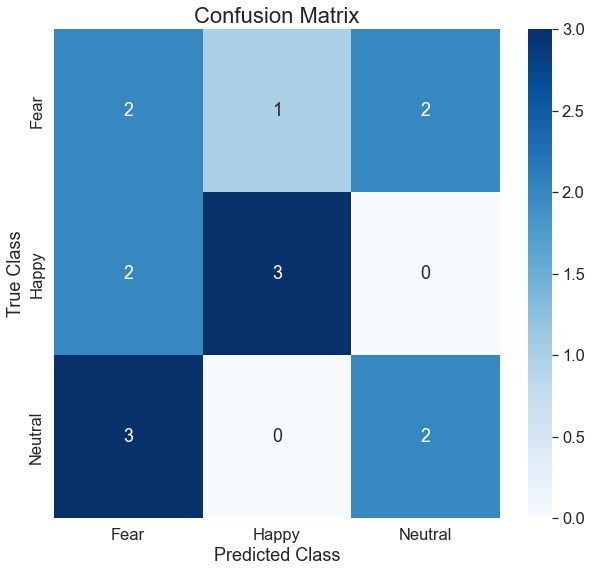

In [46]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [47]:
# G3_EDA:

optimal_feat = ['EDA_SympN', 'SCR_Peaks_N', 'EDA_Tonic_Mean', 'EDA_Tonic_Var', 'EDA_Tonic_Skew', 'EDA_Phasic_Mean', 'SCR_Height_Var', 'SCR_Height_Kurt', 'SCR_Amplitude_Skew', 'SCR_RiseTime_Skew', 'SCR_RecoveryTime_Mean']

In [48]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G3_EDA')

In [49]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g3_eda_best_results', 'rb'))
print(best_results)

C                                                               10
gamma                                                          1.0
degree                                                           -
kernel                                                         rbf
AccuracyTrain                                                0.675
AccuracyTest                                              0.566667
FearTrain                                                 0.715909
FearTest                                                  0.590909
HappyTrain                                                0.636364
HappyTest                                                 0.651163
NeutralTrain                                              0.666667
NeutralTest                                               0.424242
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 16, 1...
IndexTest        [14, 5, 0, 25, 20, 15, 40, 35, 30, 59, 50, 45,...
Name: 26, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.656     0.787     0.716        80
       Happy      0.662     0.613     0.636        80
     Neutral      0.714     0.625     0.667        80

    accuracy                          0.675       240
   macro avg      0.678     0.675     0.673       240
weighted avg      0.678     0.675     0.673       240


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.542     0.650     0.591        20
       Happy      0.609     0.700     0.651        20
     Neutral      0.538     0.350     0.424        20

    accuracy                          0.567        60
   macro avg      0.563     0.567     0.555        60
weighted avg      0.563     0.567     0.555        60

--------------------------------------------------------------------------------


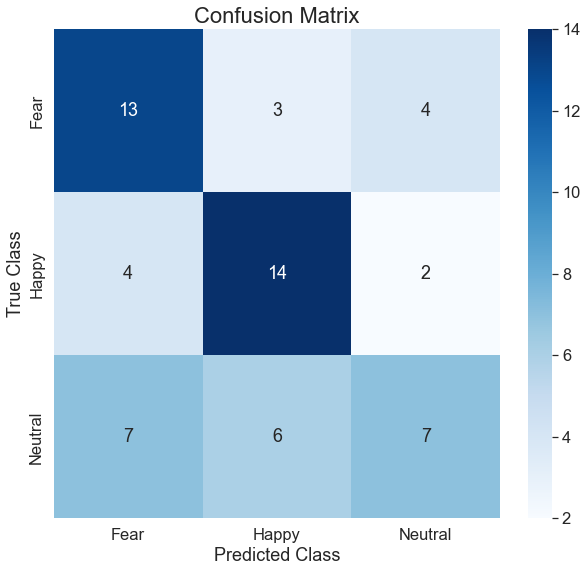

In [50]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [51]:
# Geral_EMG:

optimal_feat = ['EMG_MF_Activations_N', 'EMG_MF_all_Amplitude_Kurt', 'EMG_TR_all_Amplitude_Kurt']

In [52]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='Geral_EMG')

In [53]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_geral_emg_best_results', 'rb'))
print(best_results)

C                                                              100
gamma                                                            1
degree                                                           -
kernel                                                         rbf
AccuracyTrain                                             0.451149
AccuracyTest                                              0.436782
FearTrain                                                  0.39819
FearTest                                                       0.4
HappyTrain                                                0.517241
HappyTest                                                 0.507042
NeutralTrain                                              0.410811
NeutralTest                                                  0.375
IndexTrain       [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 15, 1...
IndexTest        [14, 5, 4, 25, 20, 19, 40, 39, 30, 55, 50, 45,...
Name: 3, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.419     0.379     0.398       116
       Happy      0.431     0.647     0.517       116
     Neutral      0.551     0.328     0.411       116

    accuracy                          0.451       348
   macro avg      0.467     0.451     0.442       348
weighted avg      0.467     0.451     0.442       348


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.423     0.379     0.400        29
       Happy      0.429     0.621     0.507        29
     Neutral      0.474     0.310     0.375        29

    accuracy                          0.437        87
   macro avg      0.442     0.437     0.427        87
weighted avg      0.442     0.437     0.427        87

--------------------------------------------------------------------------------


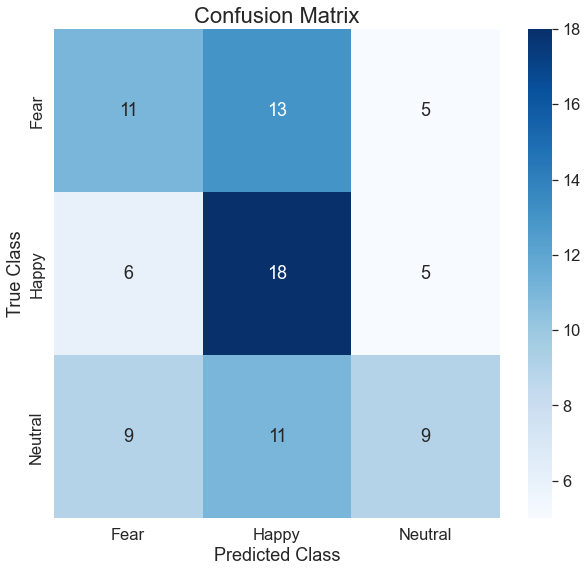

In [54]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [55]:
# G1_EMG:

optimal_feat = ['EMG_MF_Duration_Skew', 'EMG_MF_Duration_Kurt', 'EMG_MF_MeanPeaksAct_Kurt', 'EMG_MF_all_Amplitude_Var', 'EMG_TR_Activations_N', 'EMG_TR_Duration_Kurt', 'EMG_TR_MeanPeaksAct_Skew', 'EMG_TR_all_Amplitude_Var', 'EMG_TR_all_Amplitude_Skew']

In [56]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G1_EMG')

In [57]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g1_emg_best_results', 'rb'))
print(best_results)

C                                                               10
gamma                                                            1
degree                                                           3
kernel                                                        poly
AccuracyTrain                                             0.854167
AccuracyTest                                                  0.75
FearTrain                                                 0.864865
FearTest                                                  0.857143
HappyTrain                                                0.827586
HappyTest                                                 0.666667
NeutralTrain                                              0.866667
NeutralTest                                                   0.75
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 1...
IndexTest           [10, 5, 0, 25, 20, 15, 44, 35, 30, 55, 50, 49]
Name: 14, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.762     1.000     0.865        16
       Happy      0.923     0.750     0.828        16
     Neutral      0.929     0.812     0.867        16

    accuracy                          0.854        48
   macro avg      0.871     0.854     0.853        48
weighted avg      0.871     0.854     0.853        48


Classification Report Test:
              precision    recall  f1-score   support

        Fear      1.000     0.750     0.857         4
       Happy      0.600     0.750     0.667         4
     Neutral      0.750     0.750     0.750         4

    accuracy                          0.750        12
   macro avg      0.783     0.750     0.758        12
weighted avg      0.783     0.750     0.758        12

--------------------------------------------------------------------------------


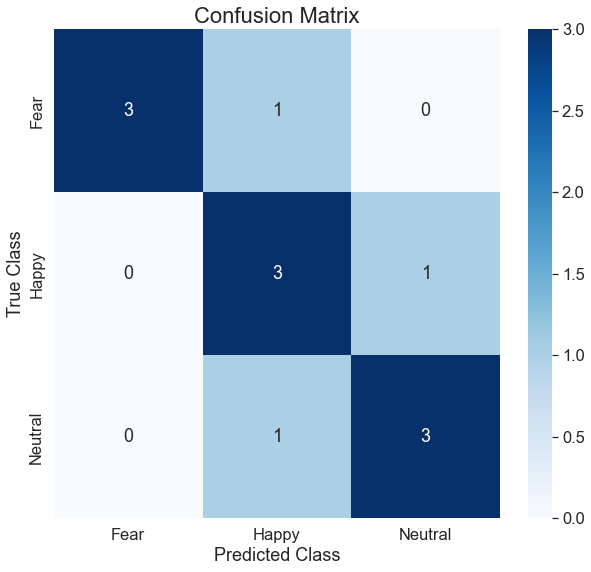

In [58]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [59]:
# G2_EMG:

optimal_feat = ['EMG_MF_Duration_Var', 'EMG_MF_Duration_Skew', 'EMG_MF_Duration_Kurt', 'EMG_MF_MeanPeaksAct_Skew', 'EMG_TR_Activations_N', 'EMG_TR_Duration_Std', 'EMG_TR_Duration_Kurt', 'EMG_TR_MeanPeaksAct_Skew']

In [60]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G2_EMG')

In [61]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g2_emg_best_results', 'rb'))
print(best_results)

C                                                            100.0
gamma                                                            -
degree                                                           -
kernel                                                      linear
AccuracyTrain                                             0.633333
AccuracyTest                                                   0.6
FearTrain                                                 0.697674
FearTest                                                  0.727273
HappyTrain                                                0.666667
HappyTest                                                 0.666667
NeutralTrain                                                   0.5
NeutralTest                                               0.285714
IndexTrain       [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 1...
IndexTest        [14, 9, 4, 29, 20, 19, 40, 35, 30, 55, 50, 45,...
Name: 3, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.652     0.750     0.698        20
       Happy      0.600     0.750     0.667        20
     Neutral      0.667     0.400     0.500        20

    accuracy                          0.633        60
   macro avg      0.640     0.633     0.621        60
weighted avg      0.640     0.633     0.621        60


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.667     0.800     0.727         5
       Happy      0.571     0.800     0.667         5
     Neutral      0.500     0.200     0.286         5

    accuracy                          0.600        15
   macro avg      0.579     0.600     0.560        15
weighted avg      0.579     0.600     0.560        15

--------------------------------------------------------------------------------


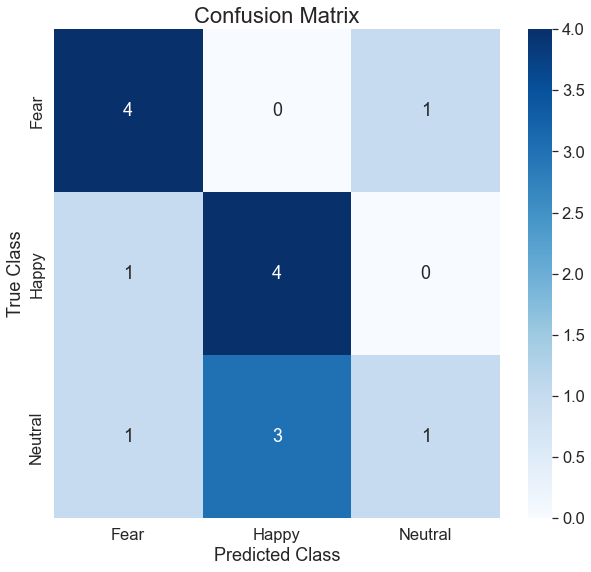

In [62]:
C_parameter = best_results['C']
gamma_parameter = 'auto'
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()

In [63]:
# G3_EMG:

optimal_feat = ['EMG_MF_Activations_N', 'EMG_MF_Duration_Var', 'EMG_MF_Duration_Skew', 'EMG_MF_Duration_Kurt', 'EMG_MF_MeanPeaksAct_Skew', 'EMG_MF_MeanPeaksAct_Kurt', 'EMG_MF_all_Amplitude_Kurt', 'EMG_TR_Activations_N', 'EMG_TR_Duration_Std', 'EMG_TR_Duration_Kurt', 'EMG_TR_all_Amplitude_Var', 'EMG_TR_all_Amplitude_Skew', 'EMG_TR_all_Amplitude_Kurt']

In [64]:
# Acessing data
data = acess_data(filename='Dataset_2_features.xlsx',sheetname='G3_EMG')

In [65]:
# Acessing best results data
best_results = pickle.load(open('emotional_model_features_g3_emg_best_results', 'rb'))
print(best_results)

C                                                                1
gamma                                                            1
degree                                                           5
kernel                                                        poly
AccuracyTrain                                               0.7625
AccuracyTest                                              0.466667
FearTrain                                                 0.774194
FearTest                                                  0.458333
HappyTrain                                                0.741935
HappyTest                                                 0.512821
NeutralTrain                                              0.776978
NeutralTest                                               0.424242
IndexTrain       [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 1...
IndexTest        [10, 5, 0, 25, 20, 15, 40, 35, 30, 55, 50, 49,...
Name: 3, dtype: object



Classification Report Train:
              precision    recall  f1-score   support

        Fear      0.638     0.463     0.536        80
       Happy      0.508     0.762     0.610        80
     Neutral      0.645     0.500     0.563        80

    accuracy                          0.575       240
   macro avg      0.597     0.575     0.570       240
weighted avg      0.597     0.575     0.570       240


Classification Report Test:
              precision    recall  f1-score   support

        Fear      0.400     0.400     0.400        20
       Happy      0.391     0.450     0.419        20
     Neutral      0.353     0.300     0.324        20

    accuracy                          0.383        60
   macro avg      0.381     0.383     0.381        60
weighted avg      0.381     0.383     0.381        60

--------------------------------------------------------------------------------


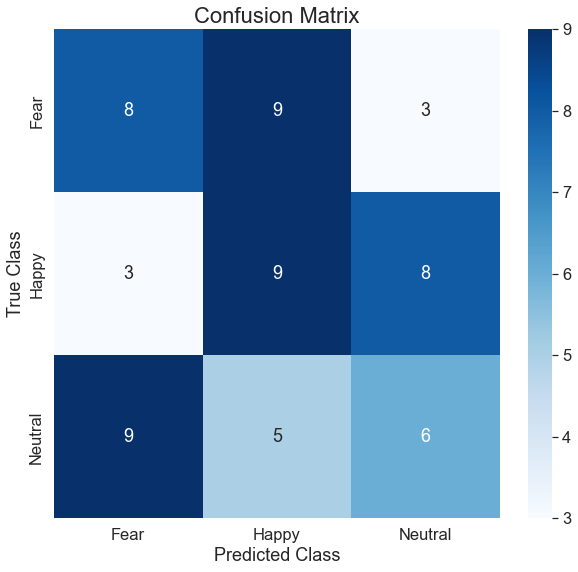

In [66]:
C_parameter = best_results['C']
gamma_parameter = best_results['gamma']
kernel_parameter = best_results['kernel']

train = data.iloc[best_results['IndexTrain'],:]
test = data.iloc[best_results['IndexTest'],:]

xtrain = train[optimal_feat].values
xtest = test[optimal_feat].values
ytrain = train['Labels'].values
ytest = test['Labels'].values

model, results_train, results_test, dic_train, dic_test, predictions_test = emotional_model (C_parameter, gamma_parameter, kernel_parameter,
                                                                           xtrain, ytrain, xtest, ytest)

# Confusion matrix:
cm = confusion_matrix(ytest, predictions_test)
cm_df = pd.DataFrame(cm, index=['Fear','Happy','Neutral'], columns = ['Fear','Happy','Neutral'])
plt.figure(figsize=(10,9))
sns.set(font_scale=1.5)
sns.heatmap(cm_df,annot=True, cmap='Blues')
plt.title('Confusion Matrix', fontsize = 22)
plt.ylabel('True Class', fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 18)
plt.show()